# Data Story

In this section, I present a preliminary exploration of data. I begin with the data <i>csv</i> file, which was obtained after the data wrangling section. The major objective of this section is to understand the general trends in the data, and gain some quick insights and relation between variables that will help buiding up the statistical model. 

In [3]:
# Import necessary Modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta

In [4]:
# Load the cleaned csv data as DataFrame 
df = pd.read_csv('C:\Capstone2\Intermediate_data\Trimmed.csv', 
                parse_dates = ['earliest_cr_line', 'issue_d', 'last_pymnt_d', 'last_credit_pull_d'])

# drop unnecessary column
df.drop('Unnamed: 0', axis = 1, inplace = True)


C:\Users\lekhn_000\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (39) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## How is the company doing? What needs improvement? 

Lending club began its service in 2007 and its gain popularity quickly after it showed up in the market. The major indicator of the club's business is the amount funded to the lenders, which has increased logarithmatically over time. In 2007, the club funded only a couple of hundred thousands dollors to the lenders, which became in the order of several millions in 2016. 

In average 85% of customer pay the loans in time. The remaining customers make late payments or are charged off. The charged off loans goes through the loan collections. Over the years, the fraction of customers (and charged off amount) has not improved. This project focusses on minimizing the fraction of <b>Late/Charged off</b> lenders. 

C:\Users\lekhn_000\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """


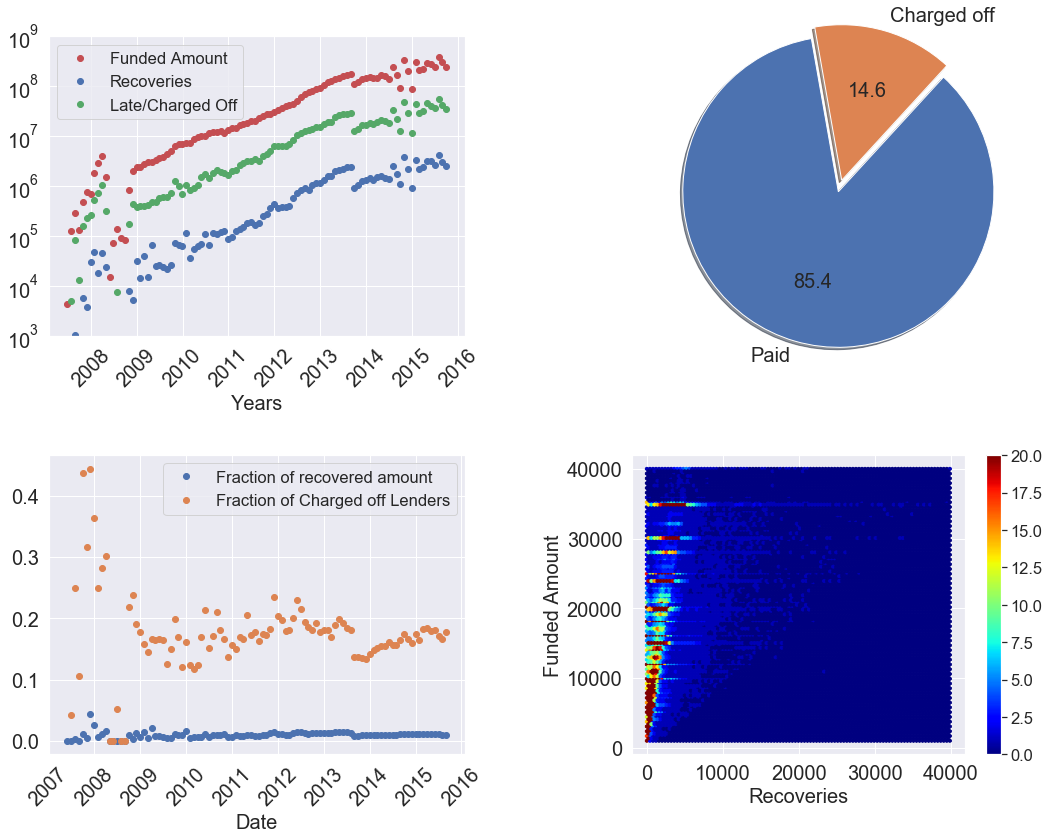

In [75]:
fig, axes = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize = [15, 12])

df_sample = df[['issue_d', 'term', 'funded_amnt', 'recoveries', 'loan_status']]

df_sample.final_d = df_sample.issue_d + pd.to_timedelta(df_sample.term, unit = 'M') 

df_sample = df_sample[df_sample.final_d < df_sample.issue_d.max()]

df_sample.index = df_sample.issue_d

df_sam =df_sample.resample('M')

plt.subplot(axes[0, 0])
plt.plot(df_sam.funded_amnt.sum(), 'ro', label = 'Funded Amount')
plt.plot(df_sam.recoveries.sum(), 'bo', label = 'Recoveries')
#axes[0, 0].tick_params(, rotation = 45)
axes[0, 0].tick_params(axis = 'x', rotation = 45, labelsize=20)
axes[0, 0].tick_params(axis = 'y', rotation = 0, labelsize=20)

###subplot II

S2 = df_sample.groupby('loan_status').count().term.plot(kind = 'pie', autopct='%.1f',startangle = 100, 
                                                        explode = (0.05, 0.05), labels = ('Paid', 'Charged off'),
                                                        shadow = True, radius = 1.3, rotatelabels = False,
                                                       fontsize=20, ax = axes[0,1])

S2.set(ylabel = '')


## subplot III
(df_sam.sum().recoveries/df_sam.sum().funded_amnt).plot(marker = 'o', ax = axes[1, 0], label = 'Fraction of recovered amount',
                                                        linewidth = 0.0)
df_sam1 = (df_sample[df_sample.loan_status == 'Current/Fully Paid']).resample('M').count()
df_sam2 = (df_sample[df_sample.loan_status != 'Current/Fully Paid']).resample('M').count()

(df_sam2.term/df_sam1.term).plot(ax = axes[1,0], linewidth = 0.0, marker = 'o', label = 'Fraction of Charged off Lenders')
axes[1, 0].legend()

axes[1, 0].tick_params(labelsize = 20)
axes[1, 0].set_xlabel('Date', fontsize = 20)
axes[1, 0].tick_params(axis = 'x', rotation = 45, labelsize=20)


df_b = df_sample.loan_status != 'Current/Fully Paid'
df_sam = df_sample[df_b]
df_sam = df_sam.resample('M')

plt.plot(df_sam.sum().funded_amnt, 'go', label = 'Late/Charged Off')

plt.semilogy()
plt.ylim(1e3, 1e9)
plt.xlabel('Years', fontsize = 20)
plt.legend()

## subplot IV
ax = plt.subplot(2,2,4)
df_sample = df[df.recoveries > 0]
plt.hexbin(df_sample.recoveries, df_sample.funded_amnt, cmap = 'jet', bins = 200, vmax = 20)
cax = plt.colorbar()

ax.set_xlabel('Recoveries', fontsize = 20)
ax.set_ylabel('Funded Amount', fontsize = 20)
ax.tick_params(axis = 'both', labelsize=20)
plt.tight_layout()

plt.subplots_adjust(hspace = 0.4, wspace = 0.4)

del df_b, df_sample, df_sam, S2, df_sam1, df_sam2

## How much investment next year?

The amount invested to the lenders grows in loagaritmic rate until mid 2015. After then, the growth slows down. The logaritmic value of investment can be modelled by a three order polynomial. This model predicts that the company needs to collect inestment of three hundred millions in the next year. 

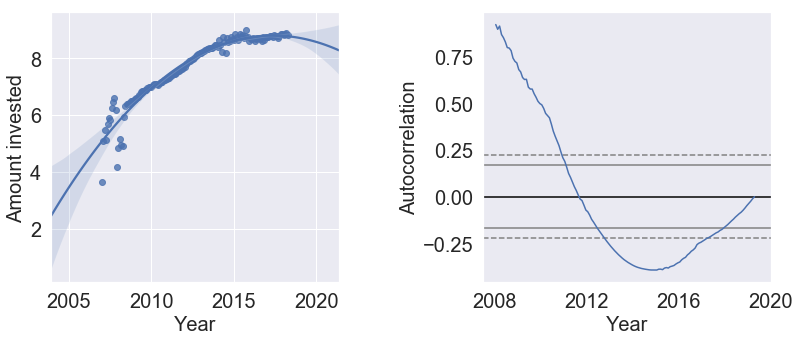

In [74]:
fig, axes = plt.subplots(nrows=1, ncols=2, squeeze=False, figsize = [10, 5])

df_sample = df[['issue_d',  'funded_amnt', 'recoveries']]
df_sample.index = df_sample.issue_d
df_sam =df_sample.resample('M').sum()

df_sam = df_sam[df_sam['funded_amnt'] > 0]
df_sam['amount_log'] = np.log10(df_sam.funded_amnt)
df_sam['year_of_business'] = 2007+ (df_sam.index - df_sam.index.min()).days/365

plt.subplot(position = [0.1, 0.15, 0.4, 0.75])
S1 = sns.regplot(data = df_sam, x = 'year_of_business', order = 3,
                 y = 'amount_log')
plt.xlabel('Year', fontsize =  20)
plt.ylabel('Amount invested', fontsize =  20)
plt.axis(fontsize = 20)
plt.grid(True, which = 'minor')
S1.tick_params(labelsize=20)

from pandas.plotting import autocorrelation_plot

S2 = autocorrelation_plot(df_sam.funded_amnt, ax = axes[0,1])
S2.set_position([0.7, 0.15, 0.4, 0.75])
S2.set_ylabel('Autocorrelation', fontsize = 20)
S2.set_xlabel('Year', fontsize = 20)

S2.set_xticks(np.arange(0.5, 150, 48))
desired_ticks = (S2.get_xticks()/12+2008).astype(int)
S2.set_xticklabels(desired_ticks, fontsize = 20, rotation = 0)
S2.tick_params(labelsize=20)

del S1, S2, df_sam, df_sample

## Who are the customers?

Most of the customers are the middle class people that have annual income less than hundred thousands and total current balance five times their current annual income.  Most of the lenders borrow funds for debt consolidation. 

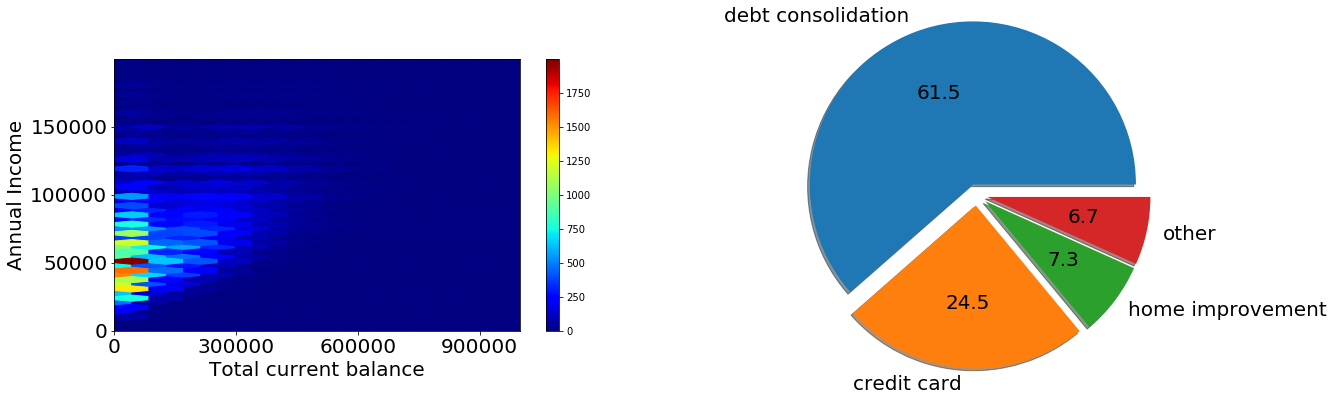

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2, squeeze=False)

S1 = plt.subplot(121)
S1.figsize = (5, 5)

plt.hexbin(df.tot_cur_bal, df.annual_inc, bins= 2000, cmap = 'jet')
plt.xlim(0, 1e6)
plt.ylim(0, 2e5)

plt.xticks(np.arange(0, 1e6, 3e5), fontsize = 20)
plt.yticks(np.arange(0, 2e5, 5e4), fontsize = 20)

plt.xlabel('Total current balance', fontsize = 20)
plt.ylabel('Annual Income', fontsize = 20)
plt.colorbar()

df.purpose = df.purpose.str.replace('_', ' ')
df_sample = df.groupby('purpose').count().sort_values(by = 'term', ascending = False)[:4]
S2 = df_sample.term.plot(kind = 'pie', autopct='%.1f',startangle = 0, 
                         shadow = True, radius = 1.5, explode = (0.1, 0.1, 0.1, 0.1),
                         rotatelabels = False, fontsize=20, figsize = (20,5), ax = axes[0,1])

S2.set(ylabel = '')
plt.show()

del S2, df_sample, S1

## What determines the loan status?

To understand the correlation between loan status with other features of the data, I did a quick preliminary survey on correlation between loan status and remaining features. It shows that previous account opend in past two years is the most important feature to consider. Some selected features that have high correlation with the loan status is below. 

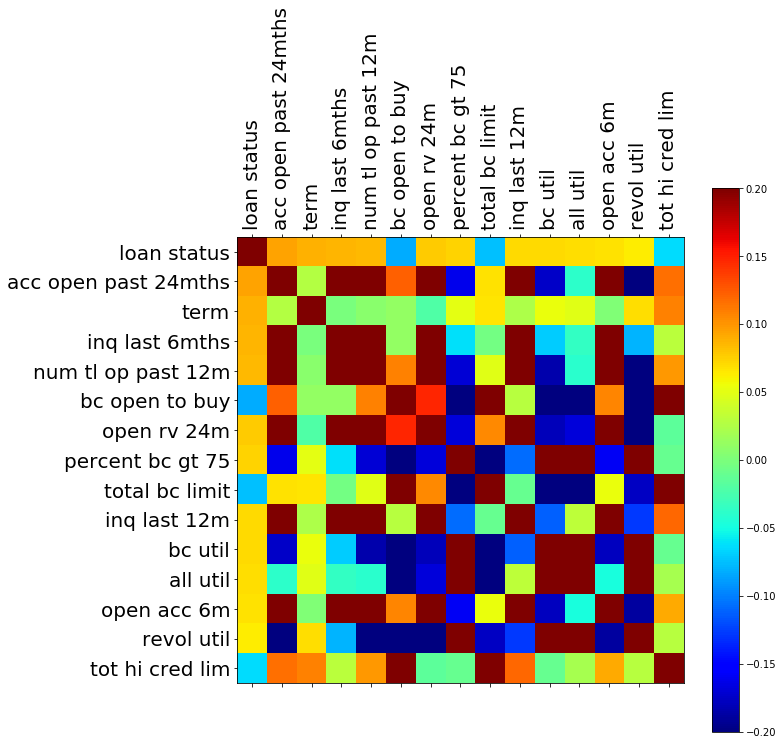

In [43]:
df_copy = df.copy(deep = False)

#delete columns that already tells the loan status

df_copy.drop(['last_pymnt_amnt', 'collection_recovery_fee', 'recoveries', 'out_prncp_inv', 
         'out_prncp', 'total_rec_prncp', 'int_rate', 'total_pymnt', 'total_pymnt_inv',
         'total_rec_late_fee', 'total_rec_int', 'emp_title', 'debt_settlement_flag', 
         'addr_state', 'purpose', 'delinq_amnt', 'hardship_flag', 'pymnt_plan', 
         'collections_12_mths_ex_med', 'chargeoff_within_12_mths', 'acc_now_delinq'],
         axis = 1, inplace = True)

df_copy.loan_status = pd.get_dummies(df_copy.loan_status, drop_first = True)

corr_mat = df_copy.corr()

#select the most relevant columns
rel_ind = list((abs(corr_mat.loan_status).\
                sort_values(ascending = False)[:15]).index)

cor_mat = corr_mat.loc[rel_ind, rel_ind]

fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111)
cax = ax.matshow(cor_mat, cmap = 'jet', vmin = -0.2, vmax = 0.2)
plt.colorbar(mappable= cax)

ax.set_xticks(np.arange(0, 15, 1))
ax.set_yticks(np.arange(0, 15, 1))

rel_ind = [rel.replace('_', ' ') for rel in rel_ind]

ax.set_xticklabels(rel_ind, rotation = 90, fontsize = 20)
ax.set_yticklabels(rel_ind, rotation = 0, fontsize = 20)

plt.show()

del df_copy, cor_mat, corr_mat

## Role of recent history? 

The credit history of lenders tell a lot about the chances that the loan remains unpaid/charged off. The lenders with higher open to buy ratio (The difference between the credit limit assigned to a cardholder account and the present balance on the account) are more likely to pay the loans. The lender with more accounts open in past years or inquiries are less likely to pay the loans in time. The error bars represents 99.99% confidence interval. 

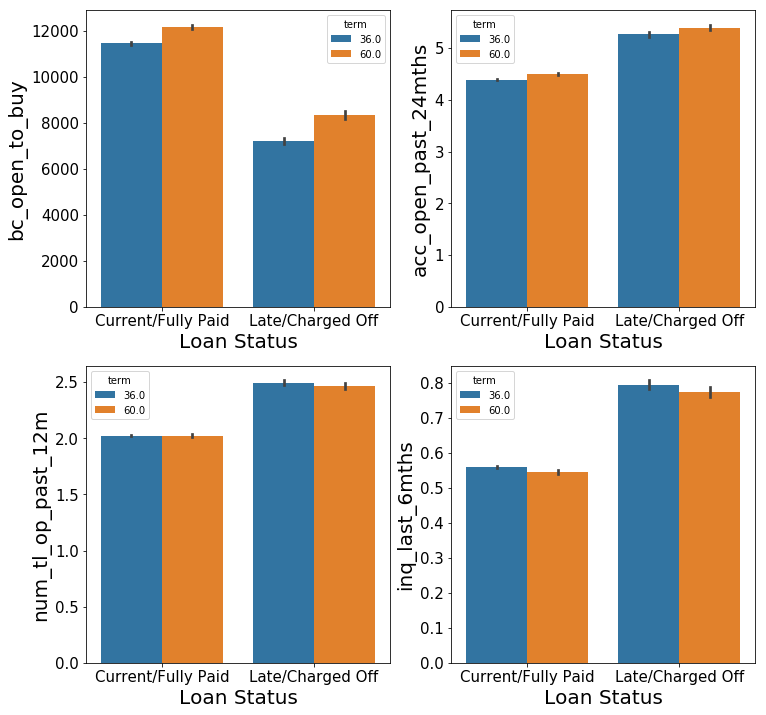

In [47]:
df_sample = df.sample(n = 1000000)

fig, axes = plt.subplots(nrows = 2, ncols = 2, squeeze=False, figsize = (12, 12))

g = sns.barplot( x = 'loan_status', y = 'bc_open_to_buy', hue = 'term',
              ci = 99.99, data = df_sample, ax = axes[0, 0])

g = sns.barplot( x = 'loan_status', y = 'acc_open_past_24mths', hue = 'term',
              ci = 99.99, data = df_sample, ax = axes[0, 1])

g = sns.barplot( x = 'loan_status', y = 'num_tl_op_past_12m', hue = 'term',
              ci = 99.99, data = df_sample, ax = axes[1, 0])

g = sns.barplot( x = 'loan_status', y = 'inq_last_6mths', hue = 'term',
              ci = 99.99, data = df_sample, ax = axes[1, 1])

for i in range(2):
    for j in range(2):
        axes[i, j].tick_params(labelsize = 15)
        axes[i, j].set_xlabel('Loan Status', fontsize = 20)
        axes[i, j].set_ylabel(axes[i, j].get_ylabel(), fontsize = 20)

del df_sample
del g
        

## Distribution of Lenders?

Lending club seem to slightly higher loans to those whose income is verified and there is a secondary application (joint application). In the case of single account, higher loans have more risk compared to the smaller ones. 

Wall time: 1min 34s


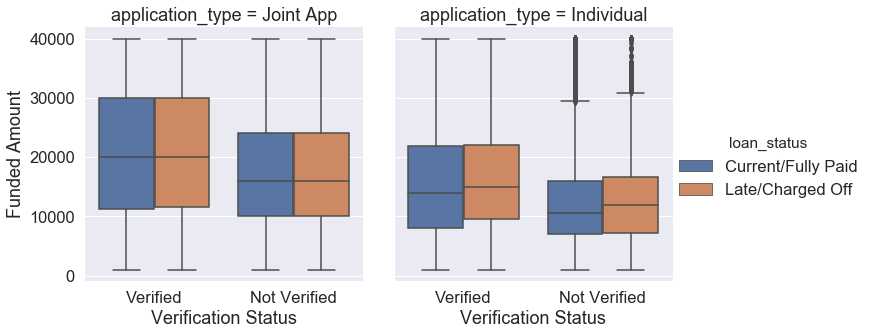

In [49]:
%%time
df_sample = df.sample(n = 1000000)

sns.set(font_scale= 1.5)
g = sns.catplot(data = df_sample, x = 'verification_status', kind = 'box', 
            col = 'application_type', y = 'funded_amnt_inv', hue = 'loan_status')

g.set_axis_labels("Verification Status", "Funded Amount")

plt.xlabel('Verification Status')

del g
del df_sample

## How is the Loan distribution? 

Loan that are approved for three years period are mostly below $25,000. Bigger loans have been issuued for three years term but only to the lenders after income verification. 

For five year term, most of the loans are of above $1000. 

C:\Users\lekhn_000\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


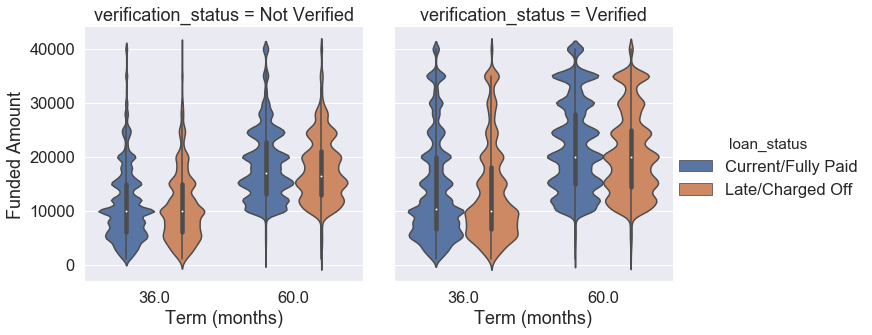

In [73]:
df_sample = df.sample(n = 1000000)

sns.set(font_scale= 1.5)
g = sns.catplot(data = df_sample, x = 'term', kind = 'violin', 
                col = 'verification_status', y = 'funded_amnt_inv', hue = 'loan_status' )

g.set_axis_labels("Term (months)", "Funded Amount")

del g
del df_sample

## How much does credit history matter?

The credit history have marginal effect on the risk. Below are the histograms or Kernel density Estimation plots of some of the features. Lenders having lower history and credit  have only slightly more risk compared to those who have long credit history. The annual income does not make much different on the risk factor. This is because the real income can be different since not all Lenders are show verified income. But the DTI (A ratio of the lenders total monthly debt to the total debt obligations). Lenders with lower DTI are more likely to pay the loans in time. 

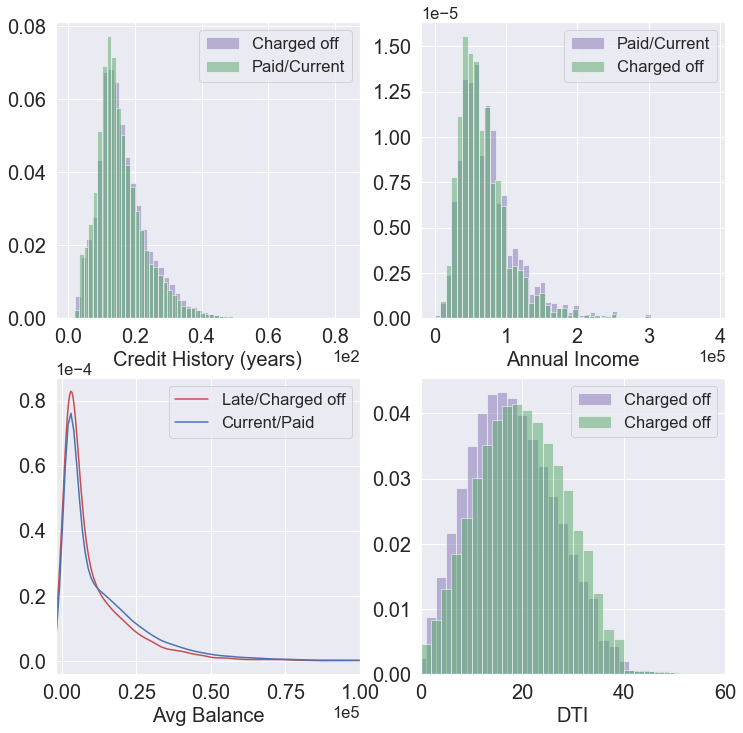

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize = (12, 12))

#subplot I

df['history'] = ((df.issue_d - df.earliest_cr_line).dt.days/365)

df_sample1 = df[df.loan_status == 'Current/Fully Paid']
S1 = df_sample1.history.hist(bins = 50, alpha = 0.5, color = 'm', ax = axes[0,0], 
                        density = True, label = 'Charged off')

df_sample2 = df[df.loan_status != 'Current/Fully Paid']
df_sample2.history.hist(bins = 50, alpha = 0.5, color = 'g', ax = S1,
                             density = True, label = 'Paid/Current')
plt.xlim(0, 55)
S1.set_xlabel('Credit History (years)', fontsize = 20)
S1.ticklabel_format(style='sci', axis='both', scilimits=(-5,0))
S1.legend()
S1.tick_params(labelsize=20)

#subplot II
S2 = df_sample1.annual_inc.hist(bins = 50, alpha = 0.5, ax = axes[0,1],
                                color = 'm', density = True, label = 'Paid/Current')

df_sample2.annual_inc.hist(bins = 50, alpha = 0.5, ax = S2,
                           color = 'g', density = True, label = 'Charged off')
plt.xlim(0, 2.5e5)
S2.legend()
S2.ticklabel_format(style='sci', axis='both', scilimits=(-5,5))
S2.set_xlabel('Annual Income', fontsize = 20)
S2.tick_params(labelsize=20)

#subplot III


df_sample = df.sample(n = 100000)

df1 = df_sample[df_sample.loan_status != 'Current/Fully Paid']
ax = df1.avg_cur_bal.plot.kde(color = 'r', ax = axes[1,0], label = 'Late/Charged off')

df2 = df_sample[df_sample.loan_status == 'Current/Fully Paid']
df2.avg_cur_bal.plot.kde(color = 'b', ax = ax, label = 'Current/Paid')
ax.set_xlim(-2e3, 1e5)

ax.legend(loc = 'best')
ax.set_xlabel('Avg Balance', fontsize = 20)
ax.set_ylabel('', fontsize = 20)
ax.ticklabel_format(style='sci', axis='both', scilimits=(-6,-5))
ax.tick_params(labelsize=20)

#Subplot IV
df_sample1.dti.hist(bins = 500, alpha = 0.5, color = 'm', ax = axes[1,1],
                    density = True, label = 'Charged off')
df_sample2.dti.hist(bins = 500, alpha = 0.5, color = 'g', ax = axes[1,1],
                    density = True, label = 'Charged off')
plt.xlim(0, 60)
axes[1,1].set_xlabel('DTI', fontsize = 20)
axes[1,1].tick_params(labelsize=20)
axes[1,1].legend(loc = 'best')

plt.subplots_adjust(hspace = 0.2, wspace = 0.2)
plt.show()

del df_sample
del df_sample1
del df_sample2

## When people stop paying ?

Regardless of whether the term is thre or five years, many lenders stop paying the loans after a year the loan is issued. 

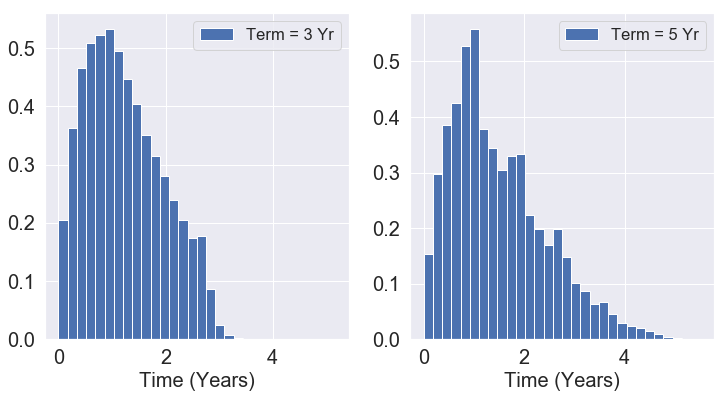

In [51]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, squeeze=False, figsize = (12, 6))

df_sample = df[(df.loan_status == 'Late/Charged Off') &
               (df.term == 36)]

duration = ((df_sample.last_pymnt_d - df_sample.issue_d).dropna().dt.days/(1*365))
duration.hist(bins = 30, density = True, ax  = axes[0,0], label = 'Term = 3 Yr')

df_sample = df[(df.loan_status == 'Late/Charged Off') &
               (df.term == 60)]

duration = ((df_sample.last_pymnt_d - df_sample.issue_d).dropna().dt.days/(1*365))
duration.hist(bins = 30, density = True, ax  = axes[0, 1], label = 'Term = 5 Yr')

for i in range(2):
    axes[0, i].set_xlabel('Time (Years)', fontsize = 20)
    axes[0, i].tick_params(labelsize=20)
    #axes[0, i].set_xlim(-0.05, 1.25)
    axes[0, i].legend()


## What is the best loan amount?

Here, we have used average of Loan status as a risk factor. The five year loan term has double the risk of three year loan term. For all categories of loan amount, five year loan have almost 50 percent more chance of being unpaid/charged off. The risk does not change much with the loan amount itself. 

The number of inquiries made by the Lender in past year makes a big difference. Lenders making 5-15 inquiries over the past years have almost double the risk of being Late/charged off. 

C:\Users\lekhn_000\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\lekhn_000\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


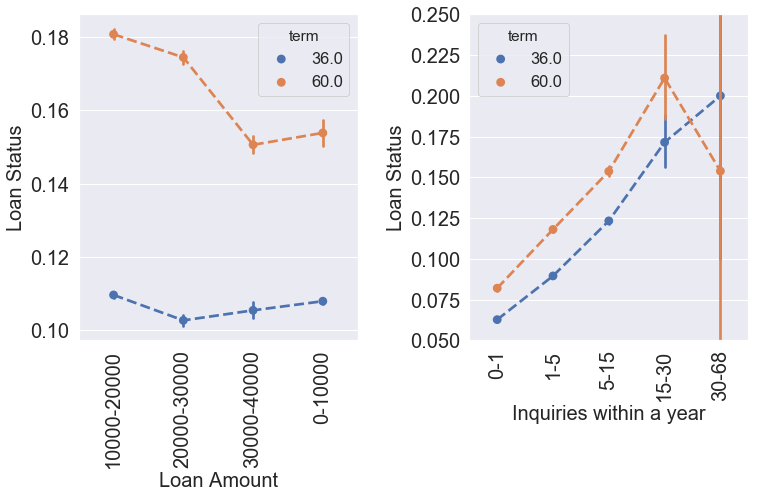

In [54]:
df['loan_status_dum'] = pd.get_dummies(df.loan_status, drop_first = True)

fig, axes = plt.subplots(nrows=1, ncols=2, squeeze=False, figsize = [12, 6])

#subplot I
loan_amnt_copy = df['loan_amnt'].copy(deep = False)

loani = 0
step = 10000
while loani <= df.loan_amnt.max():
    cond1 = df.loan_amnt <= (loani + step)
    cond2 = df.loan_amnt > loani
    cond = cond1 & cond2
    lekh_str = str(loani) + '-' + str(loani + step)
    
    loan_amnt_copy.where(~cond, lekh_str, inplace = True)
    
    loani = loani + step

df['loan_amnt_cp'] = loan_amnt_copy

df_sample = df[['loan_amnt_cp', 'loan_status_dum', 'term', 'int_rate', 'inq_last_12m']]
ax = sns.pointplot(data = df_sample, x = 'loan_amnt_cp', y = 'loan_status_dum', 
                   hue = 'term', estimator = np.mean, ax = axes[0, 0],
                   linestyles= '--')
ax.tick_params(labelsize = 20)
ax.set_xlabel('Loan Amount', fontsize = 20)
ax.set_ylabel('Loan Status', fontsize = 20)
ax.tick_params(axis = 'x', rotation = 90, labelsize=20)

## subplot II
inq_copy = df['inq_last_12m'].copy(deep = False)

interval = [0, 1, 5, 15, 30, 68]

for i in range(len(interval) - 1):
    cond1 = df.inq_last_12m >= interval[i]
    cond2 = df.inq_last_12m < interval[i+1]
    cond = cond1 & cond2
    
    lekh_str = str(interval[i]) + '-' + str(interval[i + 1])
    inq_copy.where(~cond, lekh_str, inplace = True)
    
df['inq_cp'] = inq_copy

df_sample = df[['loan_amnt_cp', 'loan_status_dum', 'term', 'int_rate', 'inq_cp']]
ax = sns.pointplot(data = df_sample, x = 'inq_cp', y = 'loan_status_dum', 
                   hue = 'term', estimator = np.mean, ax = axes[0, 1],
                   linestyles= '--')
ax.tick_params(labelsize = 20)
ax.set_xlabel('Inquiries within a year', fontsize = 20)
ax.set_ylabel('Loan Status', fontsize = 20)
ax.set_ylim(0.05, 0.25)

ax.tick_params(axis = 'x', rotation = 90, labelsize=20)
plt.subplots_adjust(wspace = 0.4)

del loani, loan_amnt_copy